In [1]:
# Running RandomForest regressions to discover a lifters best lift
# across the 3 lifts.
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.datasets import load_digits

In [2]:
# Sampling 20,000 data entries
n = 767672 
s = 40000
skip = sorted(random.sample(range(1,n+1),n-s))
data = pd.read_csv('zeroopenpowerlifting.csv', skiprows=skip)
data

,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,...,TotalKg,Place,Wilks,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date
0,Christina Tsatsoulis,F,SBD,Raw,27.0,24-34,F-OR,102.00,110,135.0,...,402.5,2,333.24,333.24,285.55,571.03,NaN,NaN,GPC-AUS,2018-10-27
1,Jasmine Hoare,F,SBD,Raw,31.0,24-34,F-OR,77.70,82.5,130.0,...,380.0,4,353.56,353.56,310.54,599.76,NaN,NaN,GPC-AUS,2018-10-27
2,Rachel Flavin,F,SBD,Wraps,35.0,35-39,F-OR,88.90,90,135.0,...,342.5,1,297.48,297.48,258.87,513.14,NaN,NaN,GPC-AUS,2018-10-27
3,Chris Lepp,M,SBD,Wraps,26.0,24-34,M-OR,82.50,82.5,250.0,...,700.0,1,468.93,468.93,452.71,712.95,NaN,Australia,GPC-AUS,2018-10-27
4,Kris Miles,M,SBD,Wraps,24.0,24-34,M-OR,89.20,90,180.0,...,557.5,10,357.54,357.54,344.62,521.87,NaN,NaN,GPC-AUS,2018-10-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,Joey Gazzo,M,SBD,Wraps,59.0,55-59,m2,112.13,125,0.0,...,580.0,1,339.38,446.29,324.57,472.64,Yes,USA,NASA,2019-06-22
39996,William Tabron,M,BD,Raw,35.5,35-39,sm2,109.77,110,0.0,...,450.0,1,264.99,264.99,253.25,NaN,Yes,USA,NASA,2019-06-15
39997,Wayne Hammes,M,BD,Single-ply,60.5,60-64,m3,124.74,125,0.0,...,420.0,1,239.44,320.84,229.17,NaN,Yes,USA,NASA,2019-10-26
39998,Britney Baker,F,SBD,Wraps,24.0,24-34,wopen,104.37,90+,0.0,...,462.5,1,380.62,380.62,325.16,647.84,Yes,USA,NASA,2020-02-22


In [3]:
# Dropping columns not needed for this test
data = data.drop(columns=['Name', 'AgeClass', 'Division',
                          'Squat4Kg', 'Bench4Kg', 'Deadlift4Kg',
                          'Place', 'Tested', 'Country', 'Federation',
                          'Date', 'IPFPoints', 'TotalKg', 'Squat1Kg',
                          'Squat2Kg', 'Squat3Kg','Bench1Kg', 'Bench2Kg',
                          'Bench3Kg', 'Deadlift1Kg', 'Deadlift2Kg',
                          'Deadlift3Kg', 'McCulloch', 'Glossbrenner',
                          'WeightClassKg'])

data.columns
data.isnull().sum()

Sex                   0
Event                 0
Equipment             0
Age                   0
BodyweightKg          0
Best3SquatKg          0
Best3BenchKg          0
Best3DeadliftKg       0
Wilks              2367
dtype: int64

In [4]:
# General dropna just  to clear those without a WILKS
data = data.dropna()

In [5]:
# Dropping athletes who did not compete in complete SBD competitions
indexNames = data[data['Event'] == 'S'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'B'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'D'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'SD'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'SB'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'BD'].index
data.drop(indexNames, inplace=True)

In [6]:
data

,Sex,Event,Equipment,Age,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,Wilks
0,F,SBD,Raw,27.0,102.00,140.0,82.5,180.0,333.24
1,F,SBD,Raw,31.0,77.70,145.0,80.0,155.0,353.56
2,F,SBD,Wraps,35.0,88.90,150.0,70.0,122.5,297.48
3,M,SBD,Wraps,26.0,82.50,272.5,160.0,267.5,468.93
4,M,SBD,Wraps,24.0,89.20,207.5,135.0,215.0,357.54
...,...,...,...,...,...,...,...,...,...
39990,M,SBD,Wraps,22.5,129.73,205.0,165.0,225.0,336.65
39992,M,SBD,Wraps,22.5,59.92,152.5,97.5,190.0,375.72
39993,M,SBD,Wraps,22.5,74.75,185.0,115.0,195.0,353.54
39995,M,SBD,Wraps,59.0,112.13,210.0,110.0,260.0,339.38


In [7]:
# Remove the last couple of columns
data = data.drop(columns = ['Event'])

In [8]:
# Convert string data to numeric
sex = {'M': 1, 'F': 0, 'Mx': 3}
equipment = {'Raw': 0, 'Wraps': 1, 'Multi-ply': 2, 'Single-ply': 3, 'Straps': 4}

data.Sex = [sex[item] for item in data.Sex]
data.Equipment = [equipment[item] for item in data.Equipment]

data

,Sex,Equipment,Age,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,Wilks
0,0,0,27.0,102.00,140.0,82.5,180.0,333.24
1,0,0,31.0,77.70,145.0,80.0,155.0,353.56
2,0,1,35.0,88.90,150.0,70.0,122.5,297.48
3,1,1,26.0,82.50,272.5,160.0,267.5,468.93
4,1,1,24.0,89.20,207.5,135.0,215.0,357.54
...,...,...,...,...,...,...,...,...
39990,1,1,22.5,129.73,205.0,165.0,225.0,336.65
39992,1,1,22.5,59.92,152.5,97.5,190.0,375.72
39993,1,1,22.5,74.75,185.0,115.0,195.0,353.54
39995,1,1,59.0,112.13,210.0,110.0,260.0,339.38


In [9]:
# Normalise the data, scaling to values between 0-1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
data[['Sex', 'Equipment', 'Age', 'BodyweightKg',
        'Wilks', 'Best3BenchKg', 'Best3DeadliftKg', 'Best3SquatKg']] = scaler.fit_transform(data[['Sex', 'Equipment', 'Age', 'BodyweightKg',
        'Wilks', 'Best3BenchKg', 'Best3DeadliftKg', 'Best3SquatKg']])

In [10]:
# So, running 3 different test and training sets.
# First for squats, then bench, finally deadlifts,
# See the model accuracy for predicting someone's lifts.
# Further experiments to see which variables are critical
# to accurate prediction. How accurate can we get with age,
# sex, weight, and equipment?

test_squat = data[['Sex', 'Equipment', 'Age', 'BodyweightKg', 'Wilks']]

target_squat = data[['Best3SquatKg']]

test_bench = data[['Sex', 'Equipment', 'Age', 'BodyweightKg', 'Wilks']]

target_bench = data[['Best3BenchKg']]

test_dead = data[['Sex', 'Equipment', 'Age', 'BodyweightKg', 'Wilks']]

target_dead = data[['Best3DeadliftKg']]

In [11]:
# Preparing sets
S = test_squat
s = target_squat
B = test_bench
b = target_bench
D = test_dead
d = target_dead

In [12]:
# Split sets into training and test sets
from sklearn.model_selection import train_test_split
S_train, S_test, s_train, s_test = train_test_split(S, s, test_size=0.1, random_state=3)
B_train, B_test, b_train, b_test = train_test_split(B, b, test_size=0.1, random_state=3)
D_train, D_test, d_train, d_test = train_test_split(D, d, test_size=0.1, random_state=3)

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

model = LinearRegression()

In [14]:
model.fit(S_train, s_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [15]:
S_pred = model.predict(S_test)
from sklearn.metrics import r2_score
print("R2-score: %.2f" % r2_score(S_pred , s_test))

R2-score: 0.92


In [16]:
model.fit(B_train, b_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [17]:
B_pred = model.predict(B_test)
from sklearn.metrics import r2_score
print("R2-score: %.2f" % r2_score(B_pred , b_test))

R2-score: 0.87


In [18]:
model.fit(D_train, d_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [19]:
D_pred = model.predict(D_test)
from sklearn.metrics import r2_score
print("R2-score: %.2f" % r2_score(D_pred , d_test))

R2-score: 0.89


In [20]:
s_pred = pd.DataFrame(model.predict(S_test))
S_bw = pd.DataFrame(S_test['BodyweightKg'])
S_bw = S_bw.reset_index()
s_pred = s_pred.reset_index()
S_bw = S_bw.drop(columns = 'index')
s_pred = s_pred.drop(columns = 'index')
s_t = s_test.reset_index()
s_t = s_t.drop(columns = 'index')

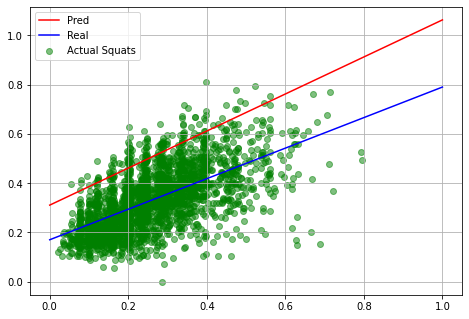

In [21]:
xfit = np.linspace(0, 1)
yfit = LinearRegression().fit(S_bw, s_pred).predict(xfit[:, None])
zfit = LinearRegression().fit(S_bw, s_test).predict(xfit[:, None])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(S_bw, s_test, color = 'g', label='Actual Squats', alpha=0.5)
plt.plot(xfit, yfit, '-r', color='red', label='Pred')
plt.plot(xfit, zfit, '-r', color='blue', label='Real')
ax.legend()
ax.grid(True)
plt.show()

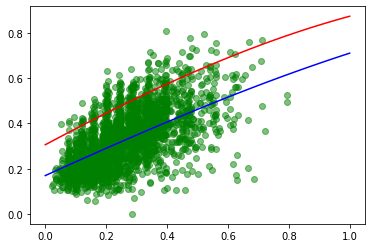

In [22]:
fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, 1)
ax.plot(xfit, np.sin(zfit), color = 'b');
ax.plot(xfit, np.sin(yfit), color = 'r');
ax.scatter(S_bw, s_test, color = 'g', alpha=0.5)